In [4]:
%load_ext autoreload
%autoreload 2
import glob
import numpy as np
from sklearn.metrics import r2_score
from sklearn import preprocessing
import pandas as pd
np.random.seed(42)
import pickle
from matplotlib import pyplot as plt
import tqdm

import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RDKit WARNING: [10:24:45] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:
!wget "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
!mkdir ../datasets/qm9
!mv qm9.csv ../datasets/qm9

--2021-07-01 10:25:17--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.117.9
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.117.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29856825 (28M) [text/csv]
Saving to: ‘qm9.csv’

qm9.csv             100%[===================>]  28.47M  8.55MB/s    in 3.8s    

2021-07-01 10:25:22 (7.47 MB/s) - ‘qm9.csv’ saved [29856825/29856825]



In [7]:
""" - "mol_id" - Molecule ID (gdb9 index) mapping to the .sdf file
    - "A" - Rotational constant (unit: GHz)
    - "B" - Rotational constant (unit: GHz)
    - "C" - Rotational constant (unit: GHz)
    - "mu" - Dipole moment (unit: D)
    - "alpha" - Isotropic polarizability (unit: Bohr^3)
    - "homo" - Highest occupied molecular orbital energy (unit: Hartree)
    - "lumo" - Lowest unoccupied molecular orbital energy (unit: Hartree)
    - "gap" - Gap between HOMO and LUMO (unit: Hartree)
    - "r2" - Electronic spatial extent (unit: Bohr^2)
    - "zpve" - Zero point vibrational energy (unit: Hartree)
    - "u0" - Internal energy at 0K (unit: Hartree)
    - "u298" - Internal energy at 298.15K (unit: Hartree)
    - "h298" - Enthalpy at 298.15K (unit: Hartree)
    - "g298" - Free energy at 298.15K (unit: Hartree)
    - "cv" - Heat capavity at 298.15K (unit: cal/(mol*K))
    - "u0_atom" - Atomization energy at 0K (unit: kcal/mol)
    - "u298_atom" - Atomization energy at 298.15K (unit: kcal/mol)
    - "h298_atom" - Atomization enthalpy at 298.15K (unit: kcal/mol)
    - "g298_atom" - Atomization free energy at 298.15K (unit: kcal/mol)
"""
df = pd.read_csv('../datasets/qm9/qm9.csv')

In [8]:
df 

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133880,gdb_133881,C1C2C3C4C5OC14C5N23,3.59483,2.198990,1.904230,1.6637,69.37,-0.2254,0.0588,0.2842,...,0.127406,-400.633868,-400.628599,-400.627654,-400.663098,23.658,-1603.983913,-1614.898804,-1623.788097,-1492.819438
133881,gdb_133882,C1N2C3C2C2C4OC12C34,3.65648,2.142370,1.904390,1.2976,69.52,-0.2393,0.0608,0.3002,...,0.127495,-400.629713,-400.624444,-400.623500,-400.658942,23.697,-1601.376613,-1612.291504,-1621.181424,-1490.211511
133882,gdb_133883,C1N2C3C4C5C2C13CN45,3.67118,2.143140,1.895010,1.2480,73.60,-0.2233,0.0720,0.2953,...,0.140458,-380.753918,-380.748619,-380.747675,-380.783148,23.972,-1667.045429,-1678.830048,-1688.312964,-1549.143391
133883,gdb_133884,C1N2C3C4C5CC13C2C45,3.52845,2.151310,1.865820,1.9576,77.40,-0.2122,0.0881,0.3003,...,0.152222,-364.720374,-364.714974,-364.714030,-364.749650,24.796,-1794.600439,-1807.210860,-1817.286772,-1670.349892


In [9]:
target = df['gap'].to_numpy()

61                               NC(=N)C=O                                    NC(=N)C=O                             [NH]C(=[NH2])C=O            5.631463\n',
 '      80                        [NH3+]CC([O-])=O                                     NCC(=O)O                               [NH3]CC(=O)[O]            10.09360\n',
 '     185                              N=C1NC=CO1                            [NH][C@@H]1NC=CO1                                 N=c1occ[nH]1            1.588400\n',

In [ ]:
# NC(=N)C#N   NC(=N)C#N    [NH]C(=[NH2])C#N 

In [23]:
df.loc[79]

mol_id                 gdb_80
smiles       [NH3+]CC([O-])=O
A                     10.1439
B                      4.0714
C                     3.02223
mu                     5.3004
alpha                   35.19
homo                  -0.2527
lumo                   0.0208
gap                    0.2735
r2                    408.028
zpve                 0.080317
u0                   -284.372
u298                 -284.367
h298                 -284.366
g298                 -284.401
cv                     17.931
u0_atom              -919.021
u298_atom            -924.576
h298_atom             -929.91
g298_atom            -857.002
Name: 79, dtype: object

In [10]:
target = target * 27211.3825435 # conversion from Hartree to meV

In [11]:
X = []

In [12]:
types = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}
symbols = {'H': 1, 'C': 6, 'N': 7, 'O': 8, 'F': 9}
bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}
labelled_graphs = {mol_id:{} for mol_id in df['mol_id']}


In [13]:
#adapted from https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/qm9.html
for mol_id, smiles, t in zip(df['mol_id'], df['smiles'], target):
    mol = Chem.MolFromSmiles(smiles) 
    # in torch geometric they set the sanitize parameter to False, I don't know what that does
    # we need it to be True for AddHs to work...
    # also they skip a few exmaples... anyways... this should get us started here
    mol = Chem.AddHs(mol)
    N = mol.GetNumAtoms()
    type_idx = []
    atomic_number = []
    aromatic = []
    sp = []
    sp2 = []
    sp3 = []
    for atom in mol.GetAtoms():
        type_idx.append(types[atom.GetSymbol()])
        atomic_number.append(atom.GetAtomicNum())
        aromatic.append(1 if atom.GetIsAromatic() else 0)
        hybridization = atom.GetHybridization()
        sp.append(1 if hybridization == HybridizationType.SP else 0)
        sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
        sp3.append(1 if hybridization == HybridizationType.SP3 else 0)

    row, col, edge_type = [], [], []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        row += [start, end]
        col += [end, start]
        edge_type += 2 * [bonds[bond.GetBondType()]]
    
    edges = np.asarray([row, col])
    labelled_graphs[mol_id]['atom_types'] = type_idx
    labelled_graphs[mol_id]['edge_types'] = edge_type
    labelled_graphs[mol_id]['edge_list'] = edges.T.tolist()
    labelled_graphs[mol_id]['target_gap_meV'] = t

In [14]:
data = {'atom_type_encoding':types, 'bond_type_encoding':bonds, 'molecular_graphs':labelled_graphs}

In [15]:
with open('../datasets/qm9/qm9_molecular_graphs.json', 'w') as f:
    json.dump(data, f)

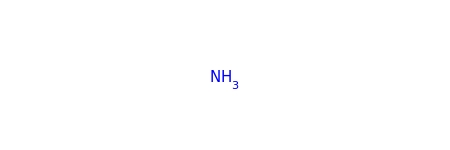

In [16]:
Chem.MolFromSmiles(df['smiles'][1]) 